# Colorization

> Lesson 23 Homework: predict the color for a black and white image

In [1]:
# |default_exp colorization

In [12]:
# |export
from functools import partial

import torch
import torch.nn.functional as F
from torch import nn
from torch.optim import AdamW, lr_scheduler
from torchmetrics.classification import MulticlassAccuracy

from slowai.coco import get_coco_dataset_colorization, get_coco_dataset_super_rez
from slowai.convs import def_device
from slowai.ddpm import AccelerateCB
from slowai.learner import (
    Callback,
    DataLoaders,
    DeviceCB,
    Learner,
    MetricsCB,
    ProgressCB,
    TrainCB,
    TrainLearner,
    only,
)
from slowai.sgd import BatchSchedulerCB
from slowai.super_rez import KaimingMixin, ResidualConvBlock
from slowai.super_rez import TinyUnetWithCrossConvolutions as Unet
from slowai.super_rez import UpsamplingResidualConvBlock, train, viz
from slowai.tinyimagenet_a import denorm, lr_find
from slowai.utils import show_image, show_images

In [3]:
%%time
dls = get_coco_dataset_super_rez(bs=128)

Map:   0%|          | 0/118287 [00:00<?, ? examples/s]

Map:   0%|          | 0/11829 [00:00<?, ? examples/s]

CPU times: user 3min 25s, sys: 21.5 s, total: 3min 47s
Wall time: 2min


Let's start with super-resolution, to see how this compares to Imagenet200 and get a sense of the compute requirements.

In [4]:
xb, yb = dls.peek()

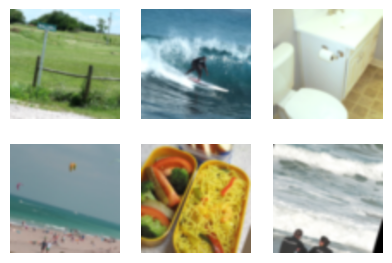

In [5]:
show_images(denorm(xb[:6, ...]), imsize=(1.6))

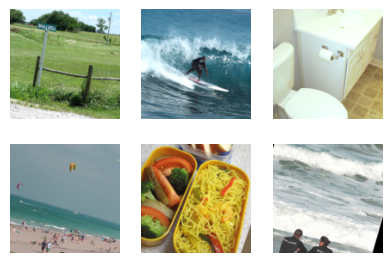

In [6]:
show_images(denorm(yb[:6, ...]), imsize=(1.6))

In [6]:
loss_fn = partial(F.mse_loss, reduction="mean")

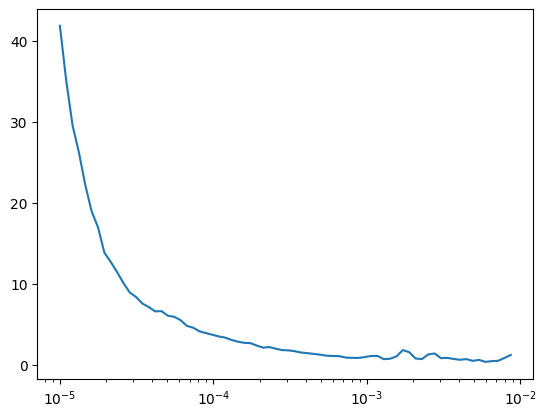

In [8]:
lr_find(
    Unet.kaiming(),
    dls,
    gamma=1.1,
    start_lr=1e-5,
    loss_fn=loss_fn,
)

loss,epoch,train
1.118,0,train
0.191,0,eval
0.124,1,train
0.079,1,eval
0.063,2,train
0.046,2,eval
0.040,3,train
0.034,3,eval
0.030,4,train
0.027,4,eval


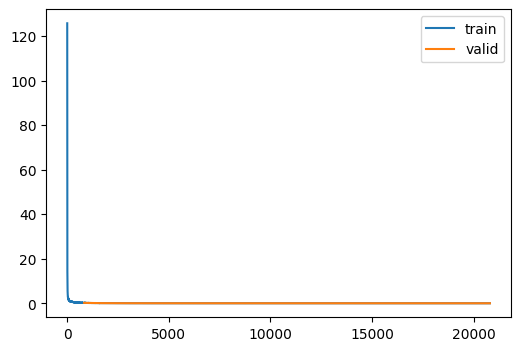

CPU times: user 2h 17min 53s, sys: 7min 55s, total: 2h 25min 48s
Wall time: 2h 57min 45s


In [9]:
%%time
un = train(
    Unet.kaiming(),
    dls,
    lr=1e-3,
    loss_fn=loss_fn,
    n_epochs=25,
)

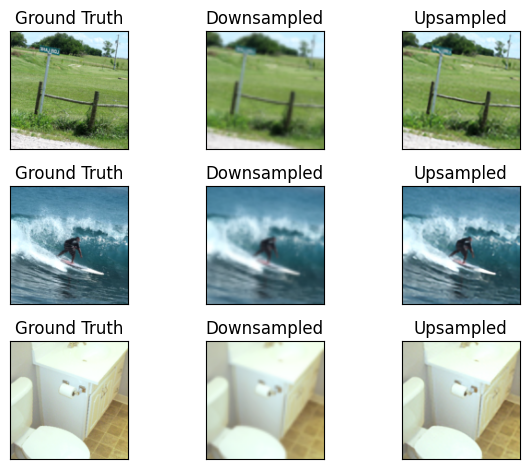

In [10]:
with torch.no_grad():
    yp = un(xb.to(def_device)).cpu()
viz(xb, yb, yp)

Looks great!

In [19]:
# |hide
torch.save(un, "../models/coco-unet-super-rez.pt")
un = torch.load("../models/coco-unet-super-rez.pt")

In [17]:
# |hide
del un, dls

Now that we can confidently say that the model does __something__, we can start to tweak it to do colorization.

The first step is use the data and model as-is and see how well it does.

In [2]:
%%time
dls = get_coco_dataset_colorization(bs=128)

Map:   0%|          | 0/118287 [00:00<?, ? examples/s]

Map:   0%|          | 0/11829 [00:00<?, ? examples/s]

CPU times: user 3min 35s, sys: 27.6 s, total: 4min 3s
Wall time: 2min 35s


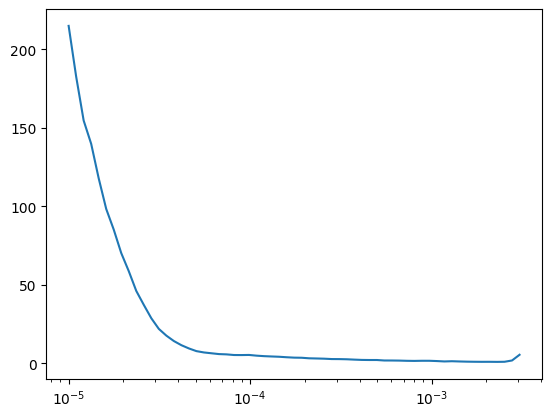

In [8]:
lr_find(
    Unet.kaiming(),
    dls,
    gamma=1.1,
    start_lr=1e-5,
    loss_fn=loss_fn,
)

loss,epoch,train
2.717,0,train
0.309,0,eval
0.214,1,train
0.155,1,eval
0.136,2,train
0.119,2,eval
0.115,3,train
0.107,3,eval
0.107,4,train
0.106,4,eval


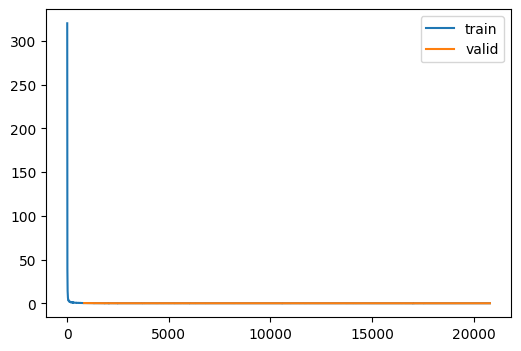

CPU times: user 2h 18min 23s, sys: 8min 6s, total: 2h 26min 29s
Wall time: 2h 59min


In [9]:
%%time
un = train(
    Unet.kaiming(),
    dls,
    lr=1e-3,
    loss_fn=loss_fn,
    n_epochs=25,
)

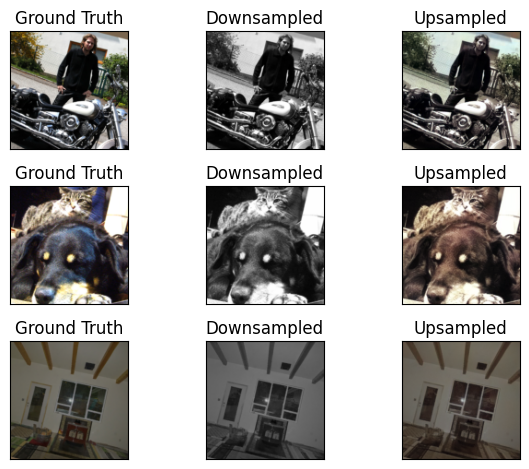

In [90]:
xb, yb = dls.peek()
xb = xb[3:, ...]
yb = yb[3:, ...]
with torch.no_grad():
    yp = un(xb.to(def_device)).cpu()
viz(xb, yb, yp)

That is the most impressive result I've ever had with machine learing :D

In [87]:
# |hide
torch.save(un, "../models/coco-unet-colorization.pt")
un = torch.load("../models/coco-unet-colorization.pt")

In [91]:
# |hide
del un

Alright, here's my crazy idea. I think the signal is a bit sparse. What if we were able to train each of the upsampler layers with a downsampled version of the input.

In [3]:
# |export
class TinyUnetWithMultiresolutionOutputs(nn.Module, KaimingMixin):
    """U-net with outputs at multiple resolutions, enabling training
    that target these lower resolutions"""

    def __init__(
        self,
        nfs: list[int] = (32, 64, 128, 256, 512, 1024),
        n_blocks=(3, 2, 2, 1, 1),
    ):
        super().__init__()
        self.start = ResidualConvBlock(3, nfs[0], ks=5, stride=1)
        cs = list(zip(nfs, nfs[1:]))
        self.downsamplers = nn.ModuleList()
        for c_in, c_out in cs:
            ld = ResidualConvBlock(c_in, c_out, stride=2)
            self.downsamplers.append(ld)
        self.upsamplers = nn.ModuleList()
        self.adapters = nn.ModuleList()
        for c_out, c_in in reversed(cs):
            lu = UpsamplingResidualConvBlock(c_in, c_out, stride=1)
            self.upsamplers.append(lu)
            a = nn.Conv2d(c_out, 3, kernel_size=3, padding=1)
            self.adapters.append(a)
        self.final = ResidualConvBlock(nfs[0], 3, stride=1, with_final_activation=False)

    def forward(self, x):
        x = self.start(x)
        x_orig = x.clone()
        xis, xos = [], []
        for l in self.downsamplers:
            x = l(x)
            xis.append(x.clone())
        for xu, l, a in zip(reversed(xis), self.upsamplers, self.adapters):
            x = l(x + xu)
            if self.training:
                # project into color space
                xc = a(x)
                xos.append(xc)
        x = self.final(x + x_orig)
        return x, xos

In [17]:
# |export
class ColorizationLearner(TrainCB):
    def predict(self, learn):
        xb, _ = learn.batch
        learn.preds = learn.model(xb)

    def get_loss(self, learn):
        _, yb = learn.batch
        xp_final, xp_intermediaries = learn.preds
        loss = learn.loss_func(xp_final, yb)
        for xp_intermediary in xp_intermediaries:
            _, _, *size = xp_intermediary.shape
            yb_resized = F.interpolate(yb, size=size)
            loss += learn.loss_func(xp_final, yb)
        learn.loss = loss

In [19]:
# |export
def train2(
    model, dls, lr=4e-3, n_epochs=25, extra_cbs=[MetricsCB()], loss_fn=F.mse_loss
):
    """Train the Unet with multiple resolution outputs"""
    T_max = len(dls["train"]) * n_epochs
    scheduler = BatchSchedulerCB(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=T_max)
    cbs = [
        DeviceCB(),
        ProgressCB(plot=True),
        scheduler,
        ColorizationLearner(),
        *extra_cbs,
    ]
    learner = Learner(
        model,
        dls,
        loss_fn,
        lr=lr,
        cbs=cbs,
        opt_func=partial(torch.optim.AdamW, eps=1e-5),
    )
    learner.fit(n_epochs)
    return model

loss,epoch,train
10.890,0,train
0.376,0,eval
1.486,1,train
0.180,1,eval
0.920,2,train
0.133,2,eval
0.741,3,train
0.123,3,eval
0.670,4,train
0.109,4,eval


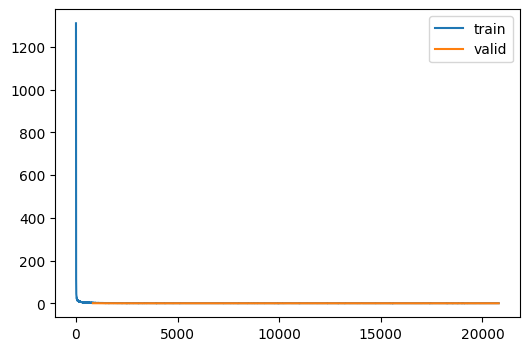

CPU times: user 1h 58min 5s, sys: 8min 2s, total: 2h 6min 7s
Wall time: 2h 56min 59s


In [21]:
%%time
un = train2(
    TinyUnetWithMultiresolutionOutputs.kaiming(),
    dls,
    lr=1e-3,
    loss_fn=loss_fn,
    n_epochs=25,
)

In [ ]:
xb, yb = dls.peek()

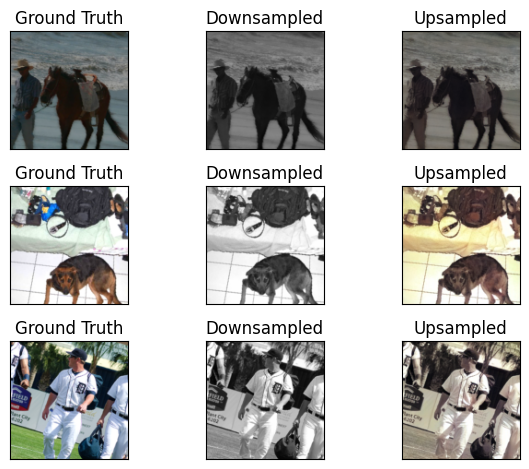

In [29]:
xb = xb[12:, ...]
yb = yb[12:, ...]
with torch.no_grad():
    yp, _ = un(xb.to(def_device))
yp = yp.cpu()
viz(xb, yb, yp)

In [14]:
#| hide
import nbdev

nbdev.nbdev_export()